# Case study: catalytic asymmetric β-C–H bond activation reactions (*Digital Discovery* **2022**)

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings


sys.path.append('../src/')
import RaRFRegressor
import utils

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'


In [3]:
# uploading data
df1 = pd.read_excel('../data/DD_reactants.xlsx', sheet_name=None)
df2 = pd.read_excel('../data/DD_data.xlsx', sheet_name='LA-LB-LC-LD').dropna()
df2['ddG'] = utils.ee2ddg(df2[r'%ee'], df2['T (˚C)']+273.15)


# getting fingerprints of substances
ligands_raw = df1['ligands'].dropna()
ligands = {ligands_raw['substrate_name'][i]: utils.smi2morgan(ligands_raw['substrate_smiles'][i])
           for i in range(np.size(ligands_raw['substrate_name']))}

coupling_partners_raw = df1['coupling_partners'].dropna()
coupling_partners = {coupling_partners_raw['substrate_name'][i]: utils.smi2morgan(coupling_partners_raw['substrate_smiles'][i])
                     for i in range(np.size(coupling_partners_raw['substrate_name']))}

substrates_raw = df1['substrates'].dropna()
substrates = {substrates_raw['substrate_name'][i]: utils.smi2morgan(substrates_raw['substrate_smiles'][i])
              for i in range(np.size(substrates_raw['substrate_name']))}

bases_raw = df1['bases'].dropna()
bases = {bases_raw['substrate_name'][i]: utils.smi2morgan(bases_raw['substrate_smiles'][i])
         for i in range(np.size(bases_raw['substrate_name']))}

catalyst_raw = df1['catalyst'].dropna()
catalysts = {catalyst_raw['substrate_name'][i]: utils.smi2morgan(catalyst_raw['substrate_smiles'][i])
            for i in range(np.size(catalyst_raw['substrate_name']))}

solvent_raw = df1['solvent'].dropna()
solvents = {solvent_raw['substrate_name'][i]: utils.smi2morgan(solvent_raw['substrate_smiles'][i])
            for i in range(np.size(solvent_raw['substrate_name']))}

additive_raw = df1['additive'].dropna()
additives = {additive_raw['substrate_name'][i]: utils.smi2morgan(additive_raw['substrate_smiles'][i])
            for i in range(np.size(additive_raw['substrate_name']))}

#fingerprints of reactions

ddG_reactions = df2['ddG']

substrates_reactions =[]
for substrate in df2['substrate']:
    substrates_reactions.append(substrates[substrate])

coupling_partners_reactions =[]
for cp in df2['coupling_partner']:
    coupling_partners_reactions.append(coupling_partners[cp])

catalysts_reactions =[]
for cat in df2['catalyst']:
    catalysts_reactions.append(catalysts[cat])

ligands_reactions = []
for l in df2['ligand']:
    ligands_reactions.append(ligands[l])

bases_reactions = []
for b in df2['base']:
    bases_reactions.append(bases[b])

additives_reactions = []
for ad in df2['additive']:
    additives_reactions.append(additives[ad])

solvents_reactions = []
for solv in df2['solvent']:
    solvents_reactions.append(solvents[solv])

reactions = pd.DataFrame(np.column_stack((ddG_reactions,
                             substrates_reactions, coupling_partners_reactions, catalysts_reactions,
                             ligands_reactions, bases_reactions, additives_reactions, solvents_reactions)))

reduced_reactions = VarianceThreshold().fit_transform(reactions)

In [4]:
df_train, df_test = train_test_split(reduced_reactions, train_size=0.8, random_state=25)
X_train, X_test = df_train[:, 1:], df_test[:, 1:]
y_train, y_test = df_train[:, 0], df_test[:, 0]

## Controls

In [ ]:
## Controls
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    min_control = utils.full_model_training_eval(X_train, y_train, X_test, 
                                                    y_test, n_calls=100, show_plot=True, n_jobs=-1)


## RaRF Regression

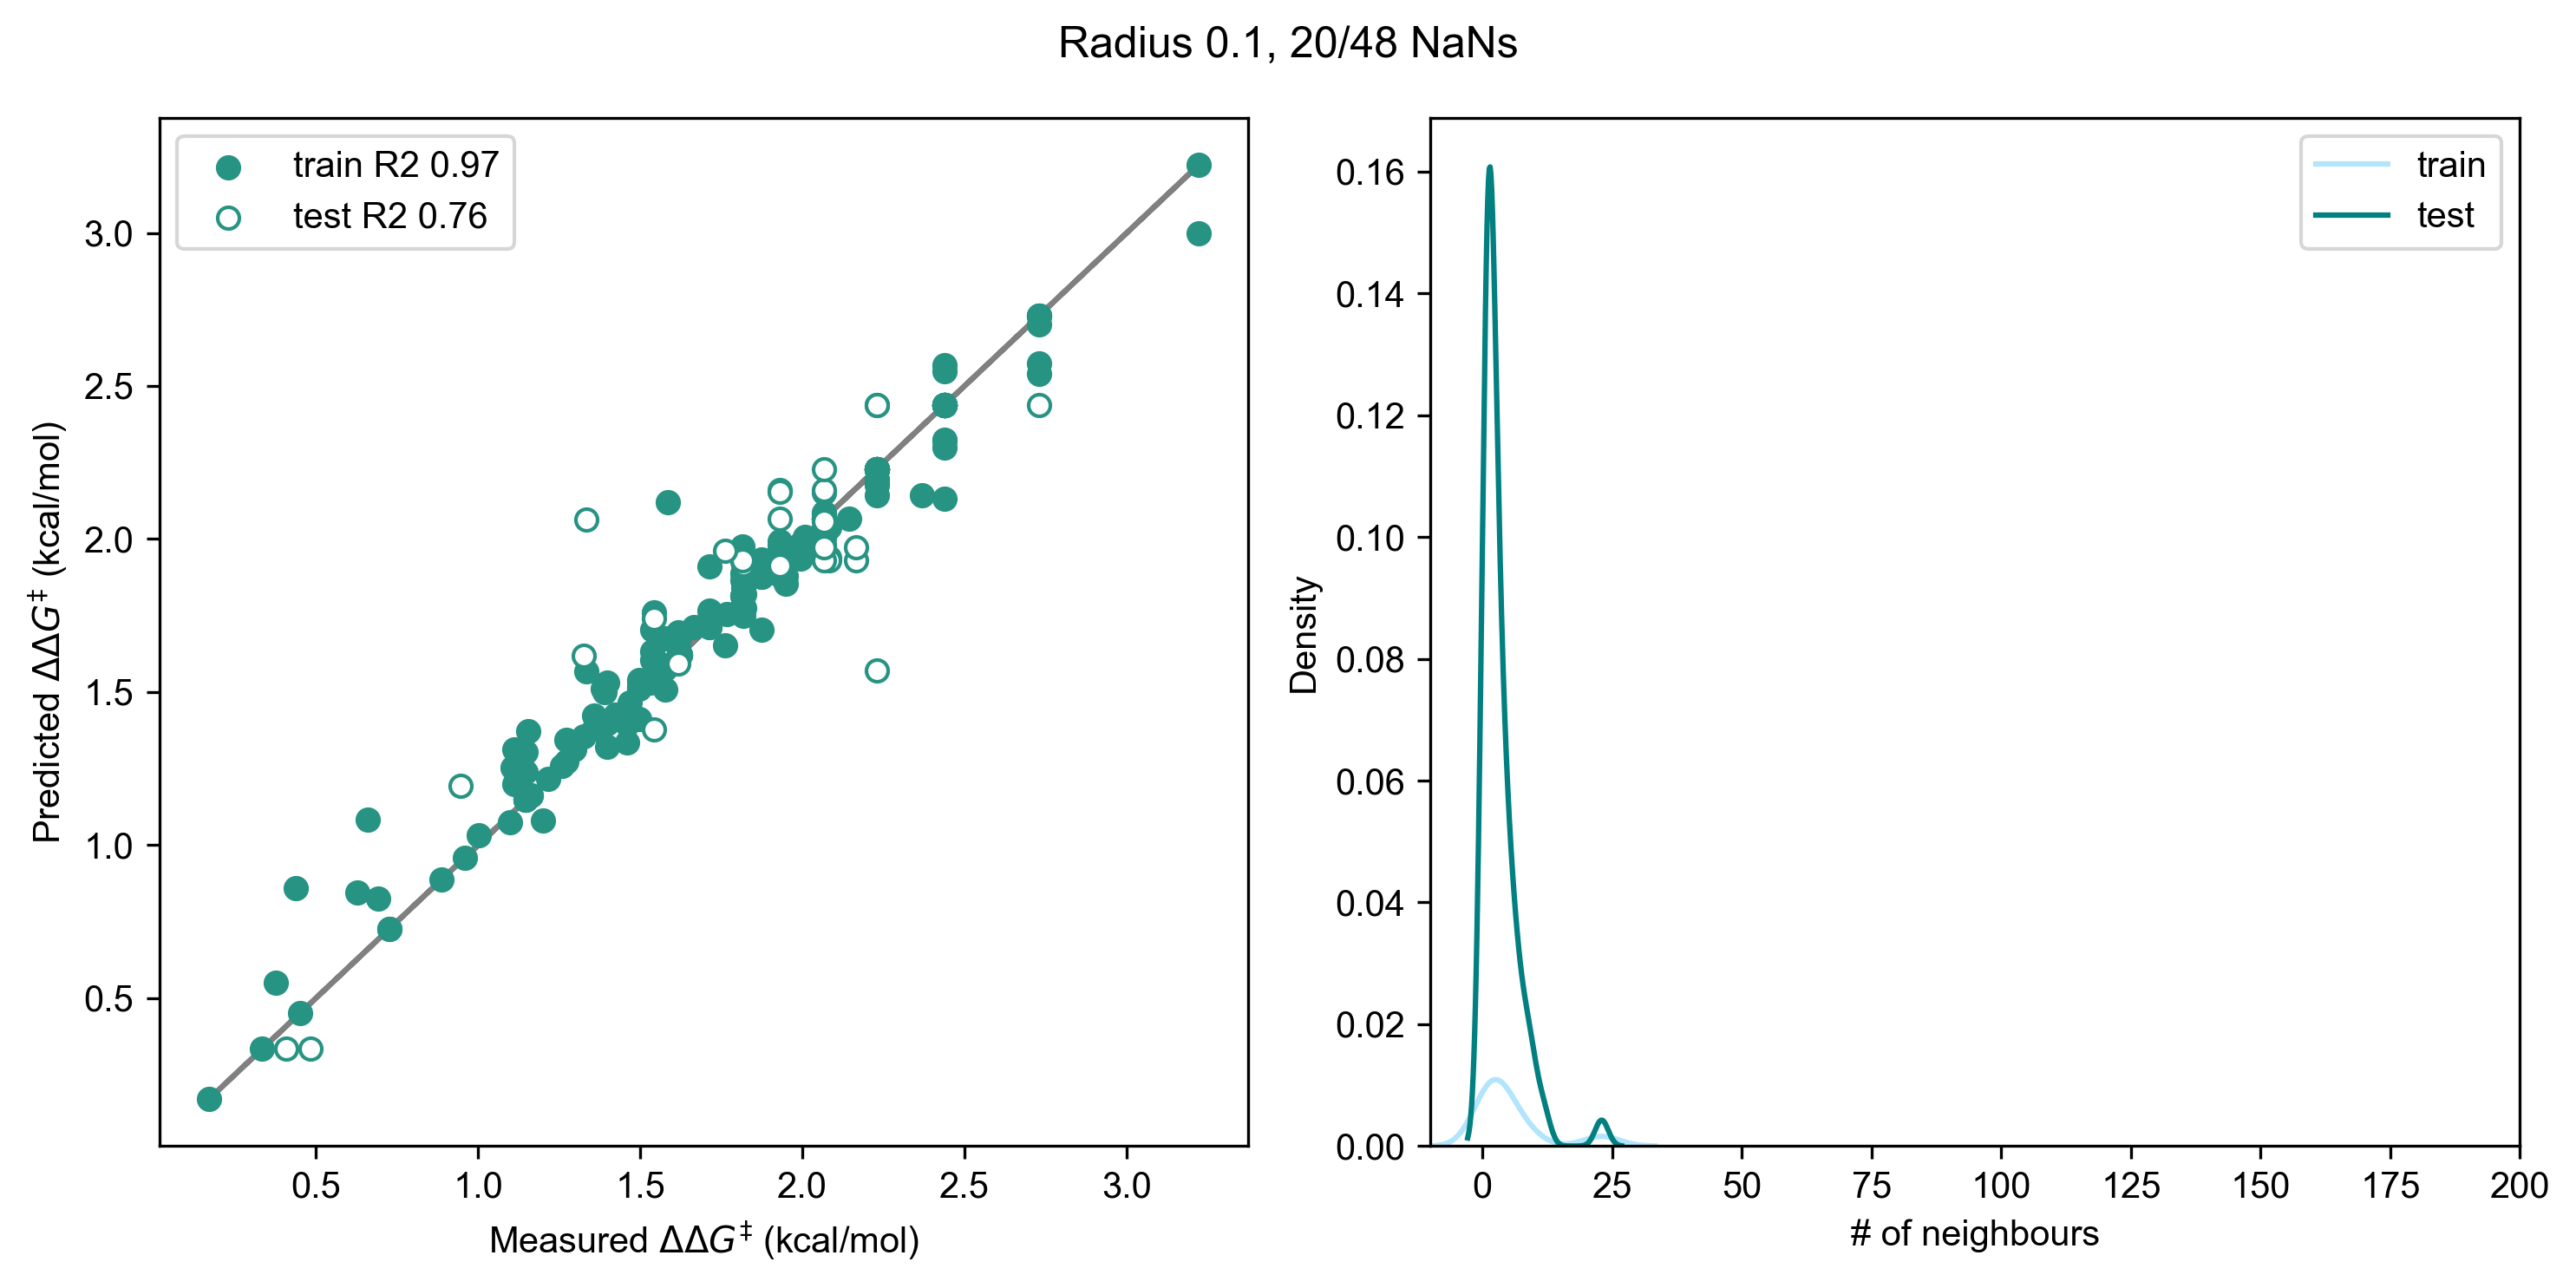

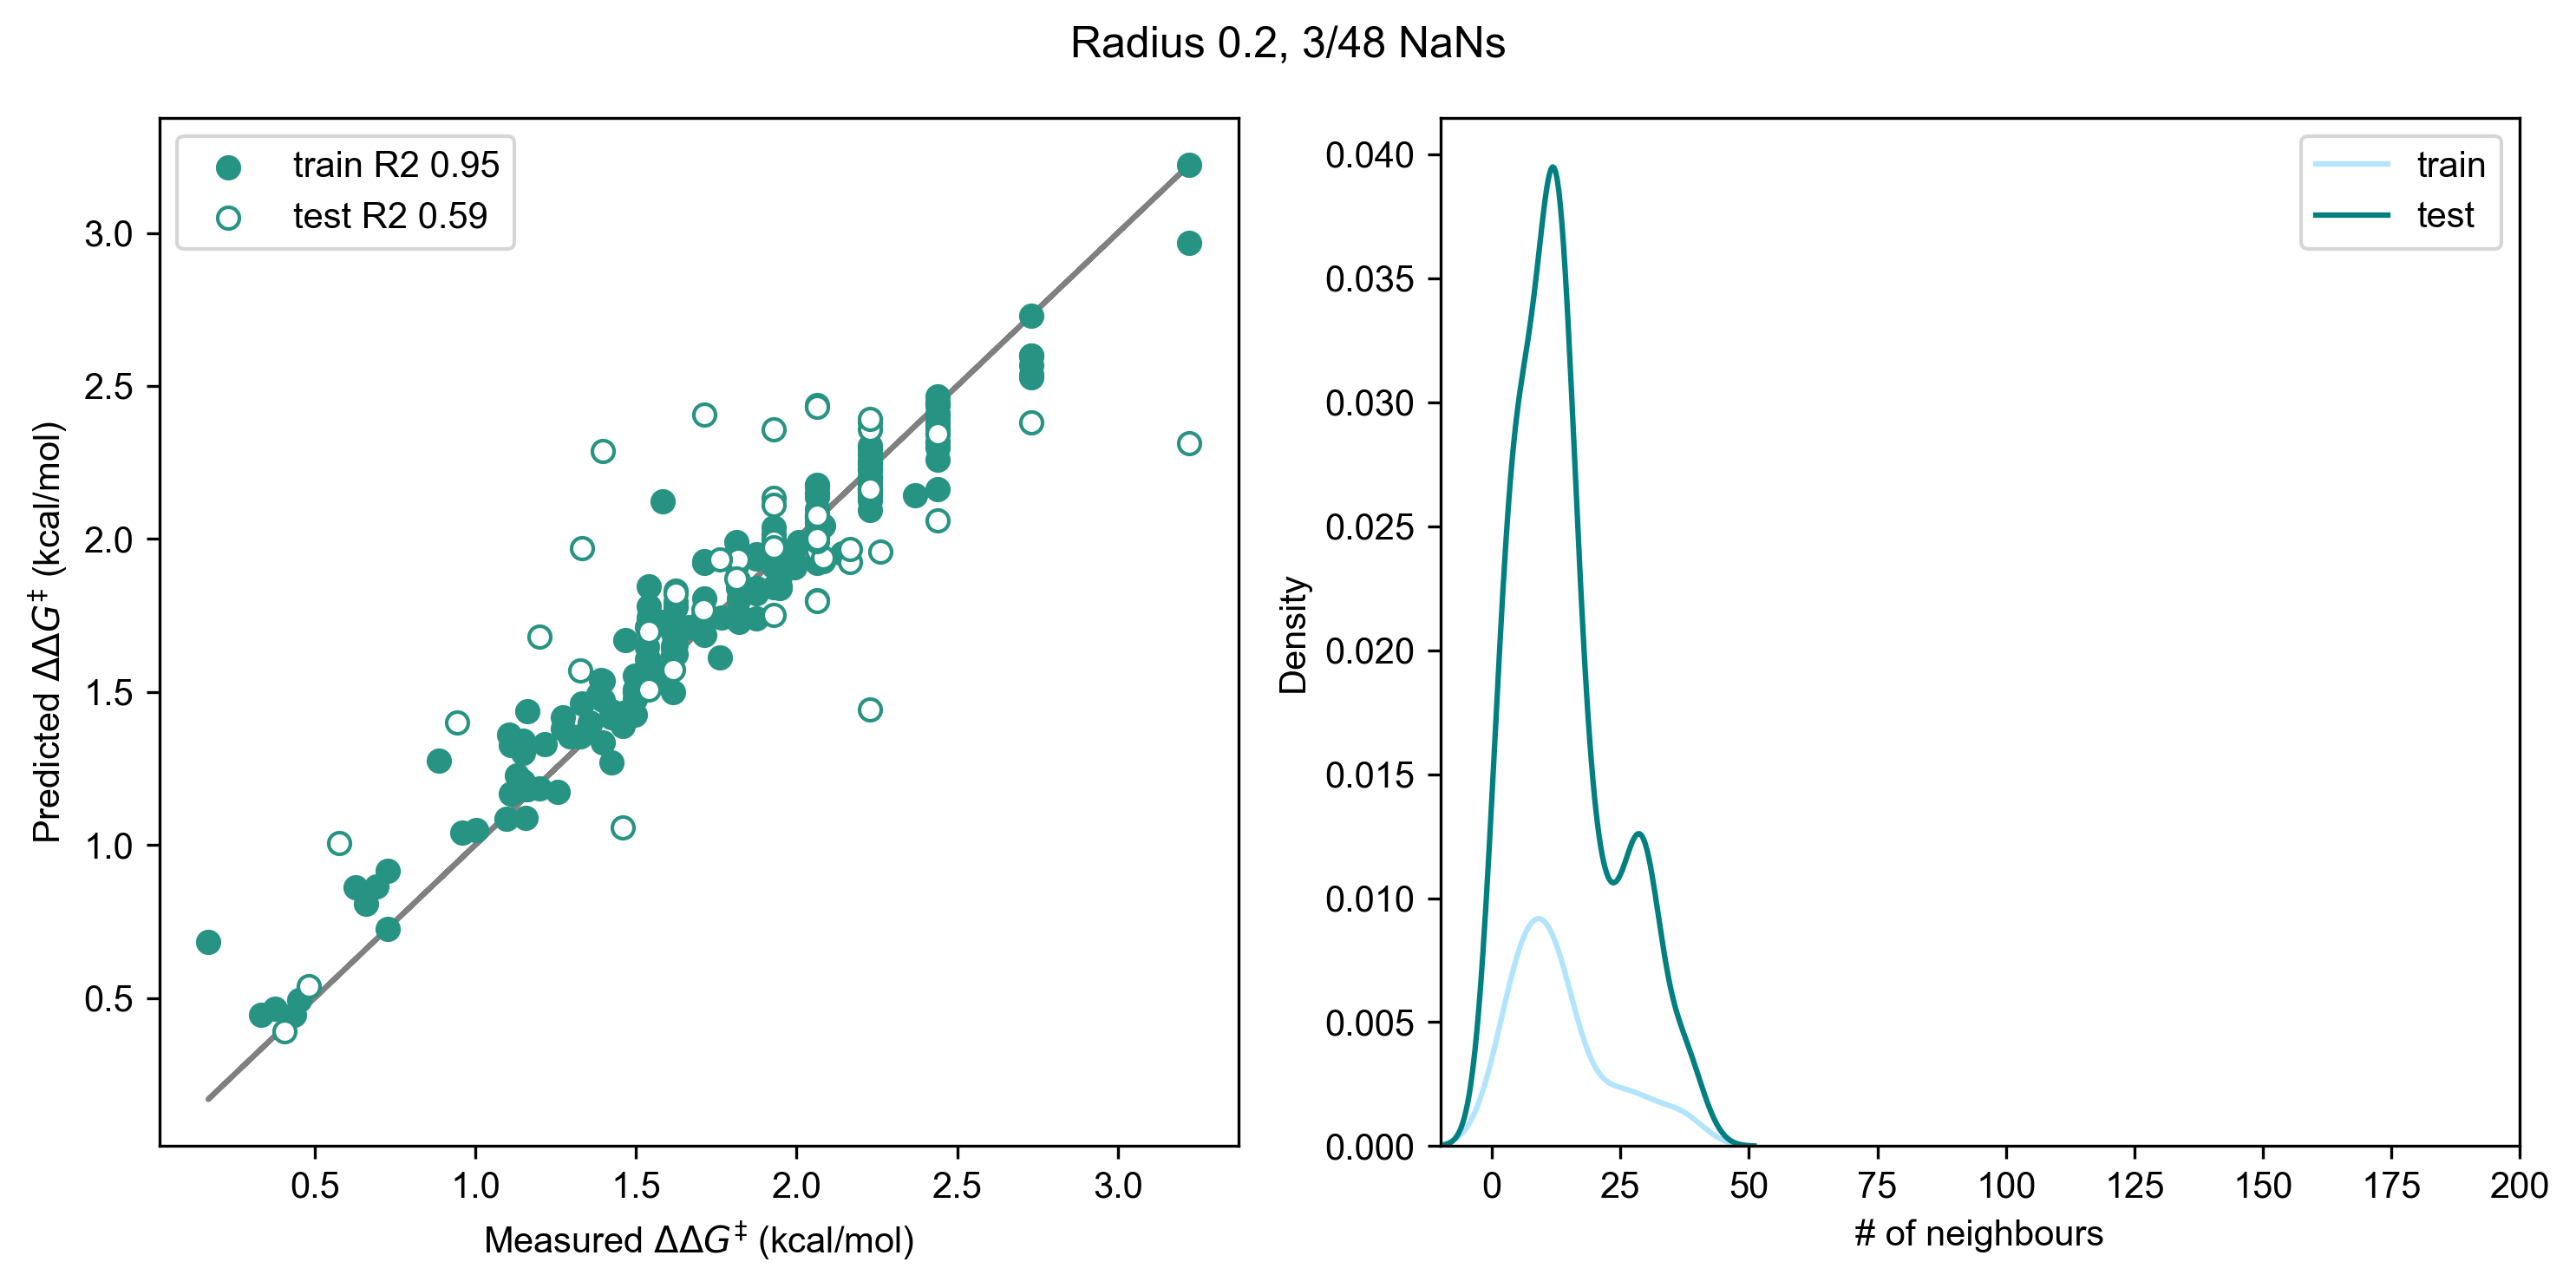

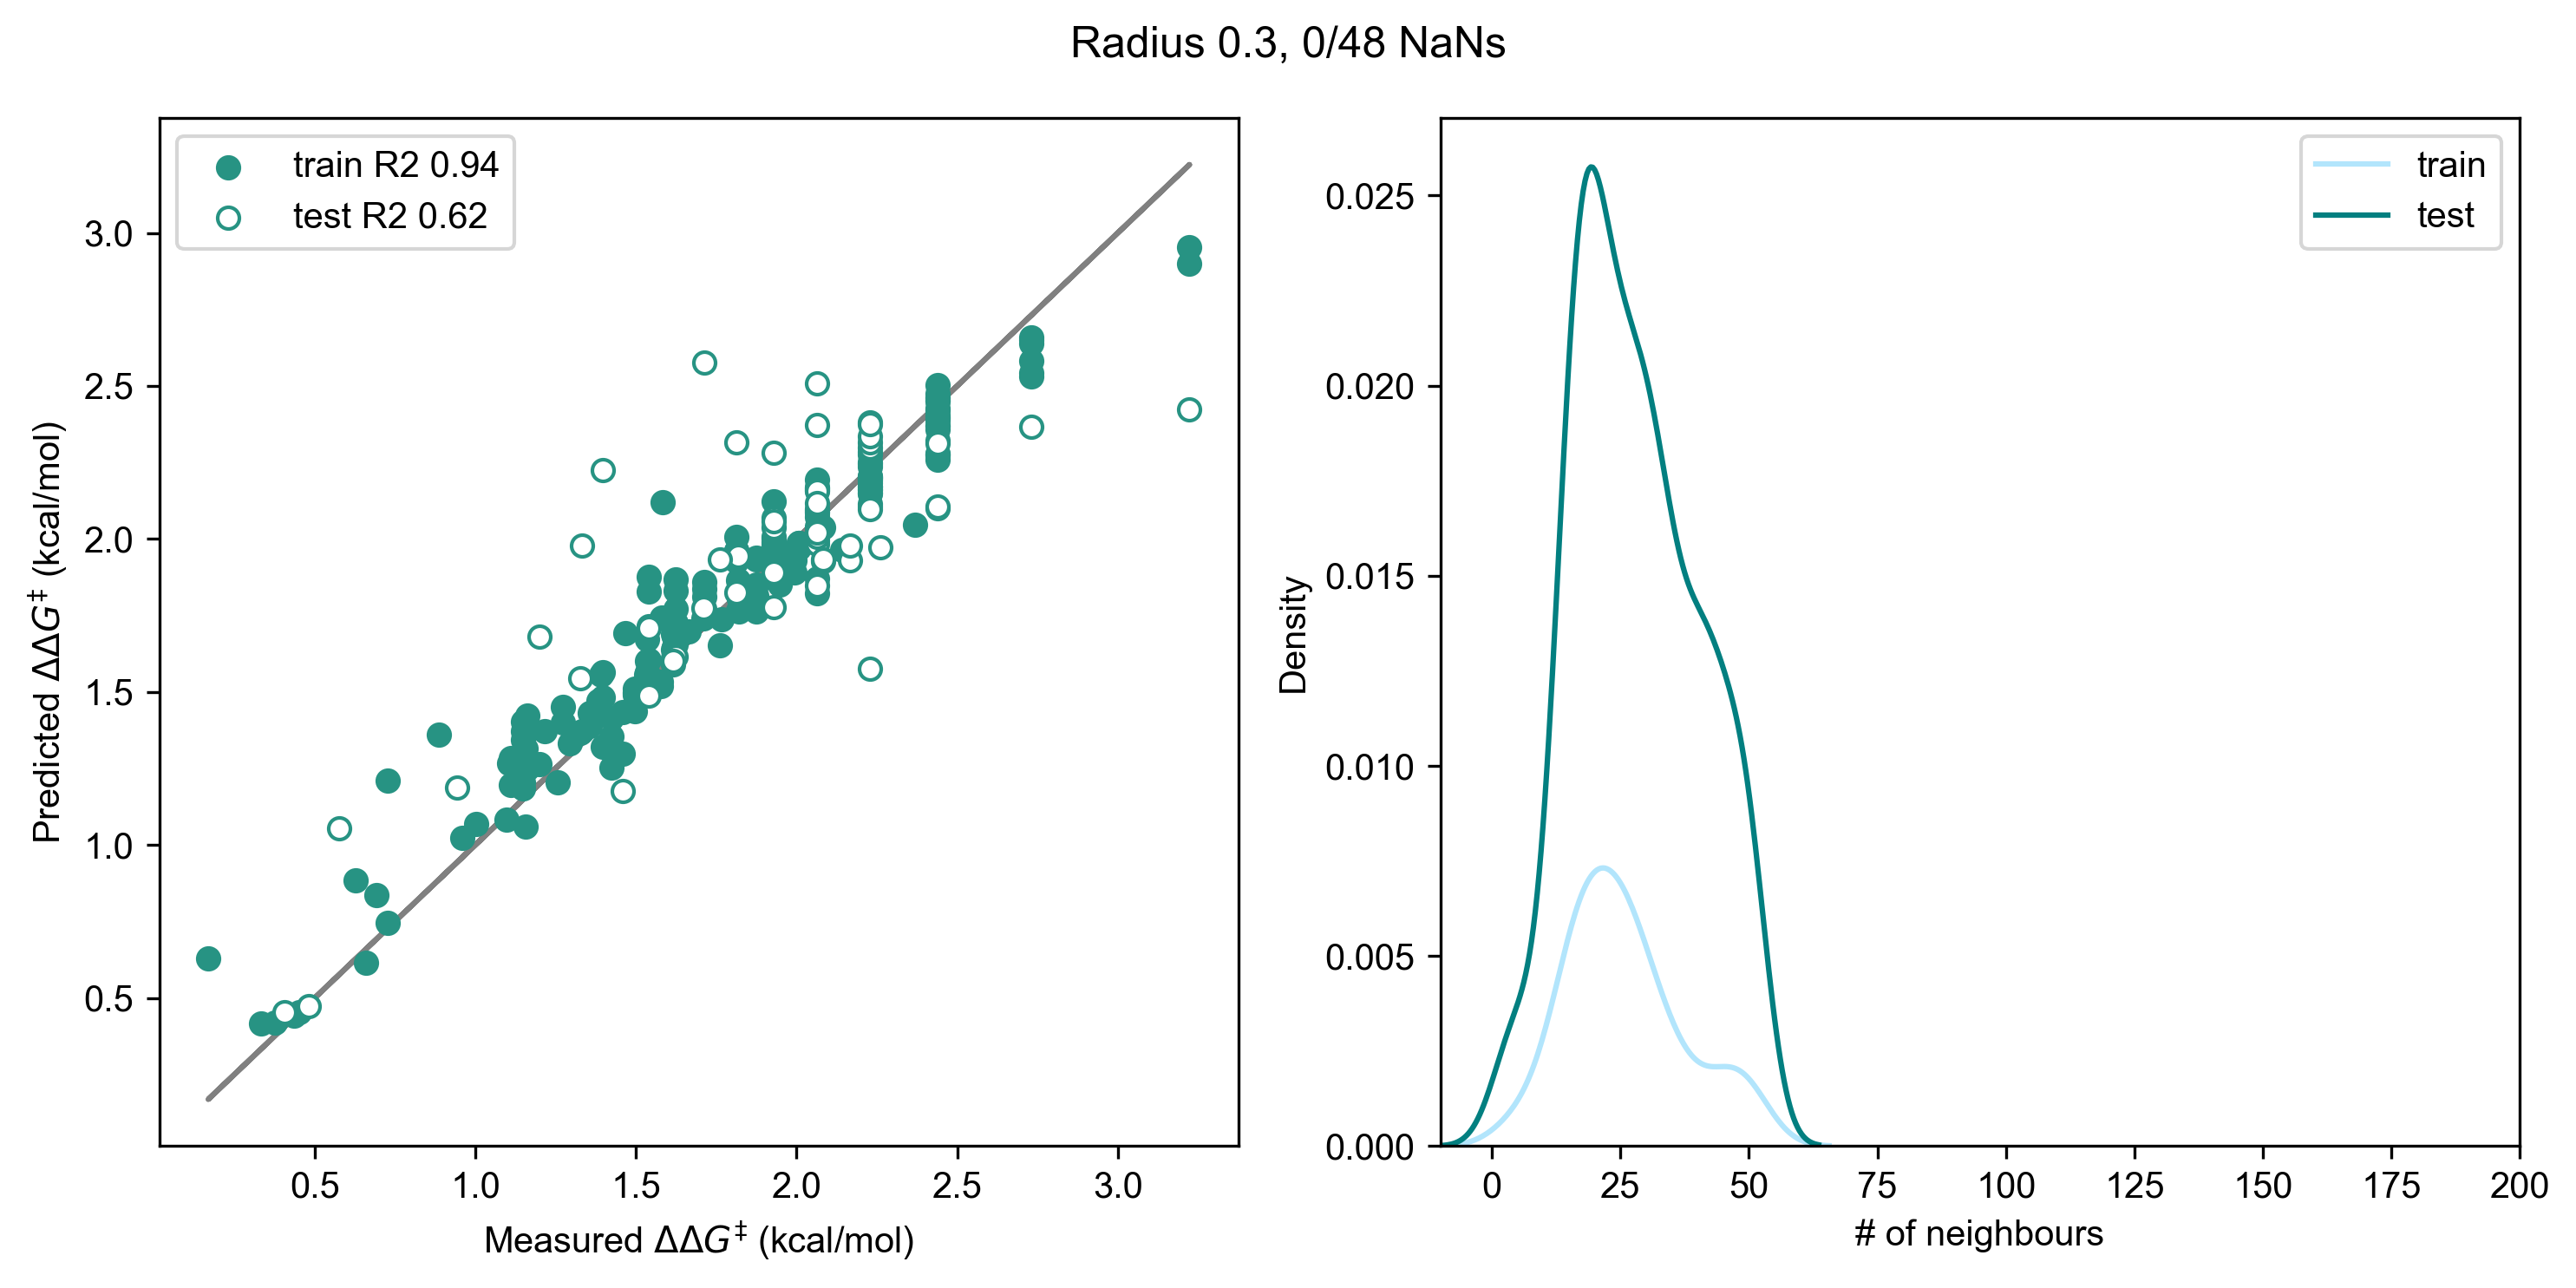

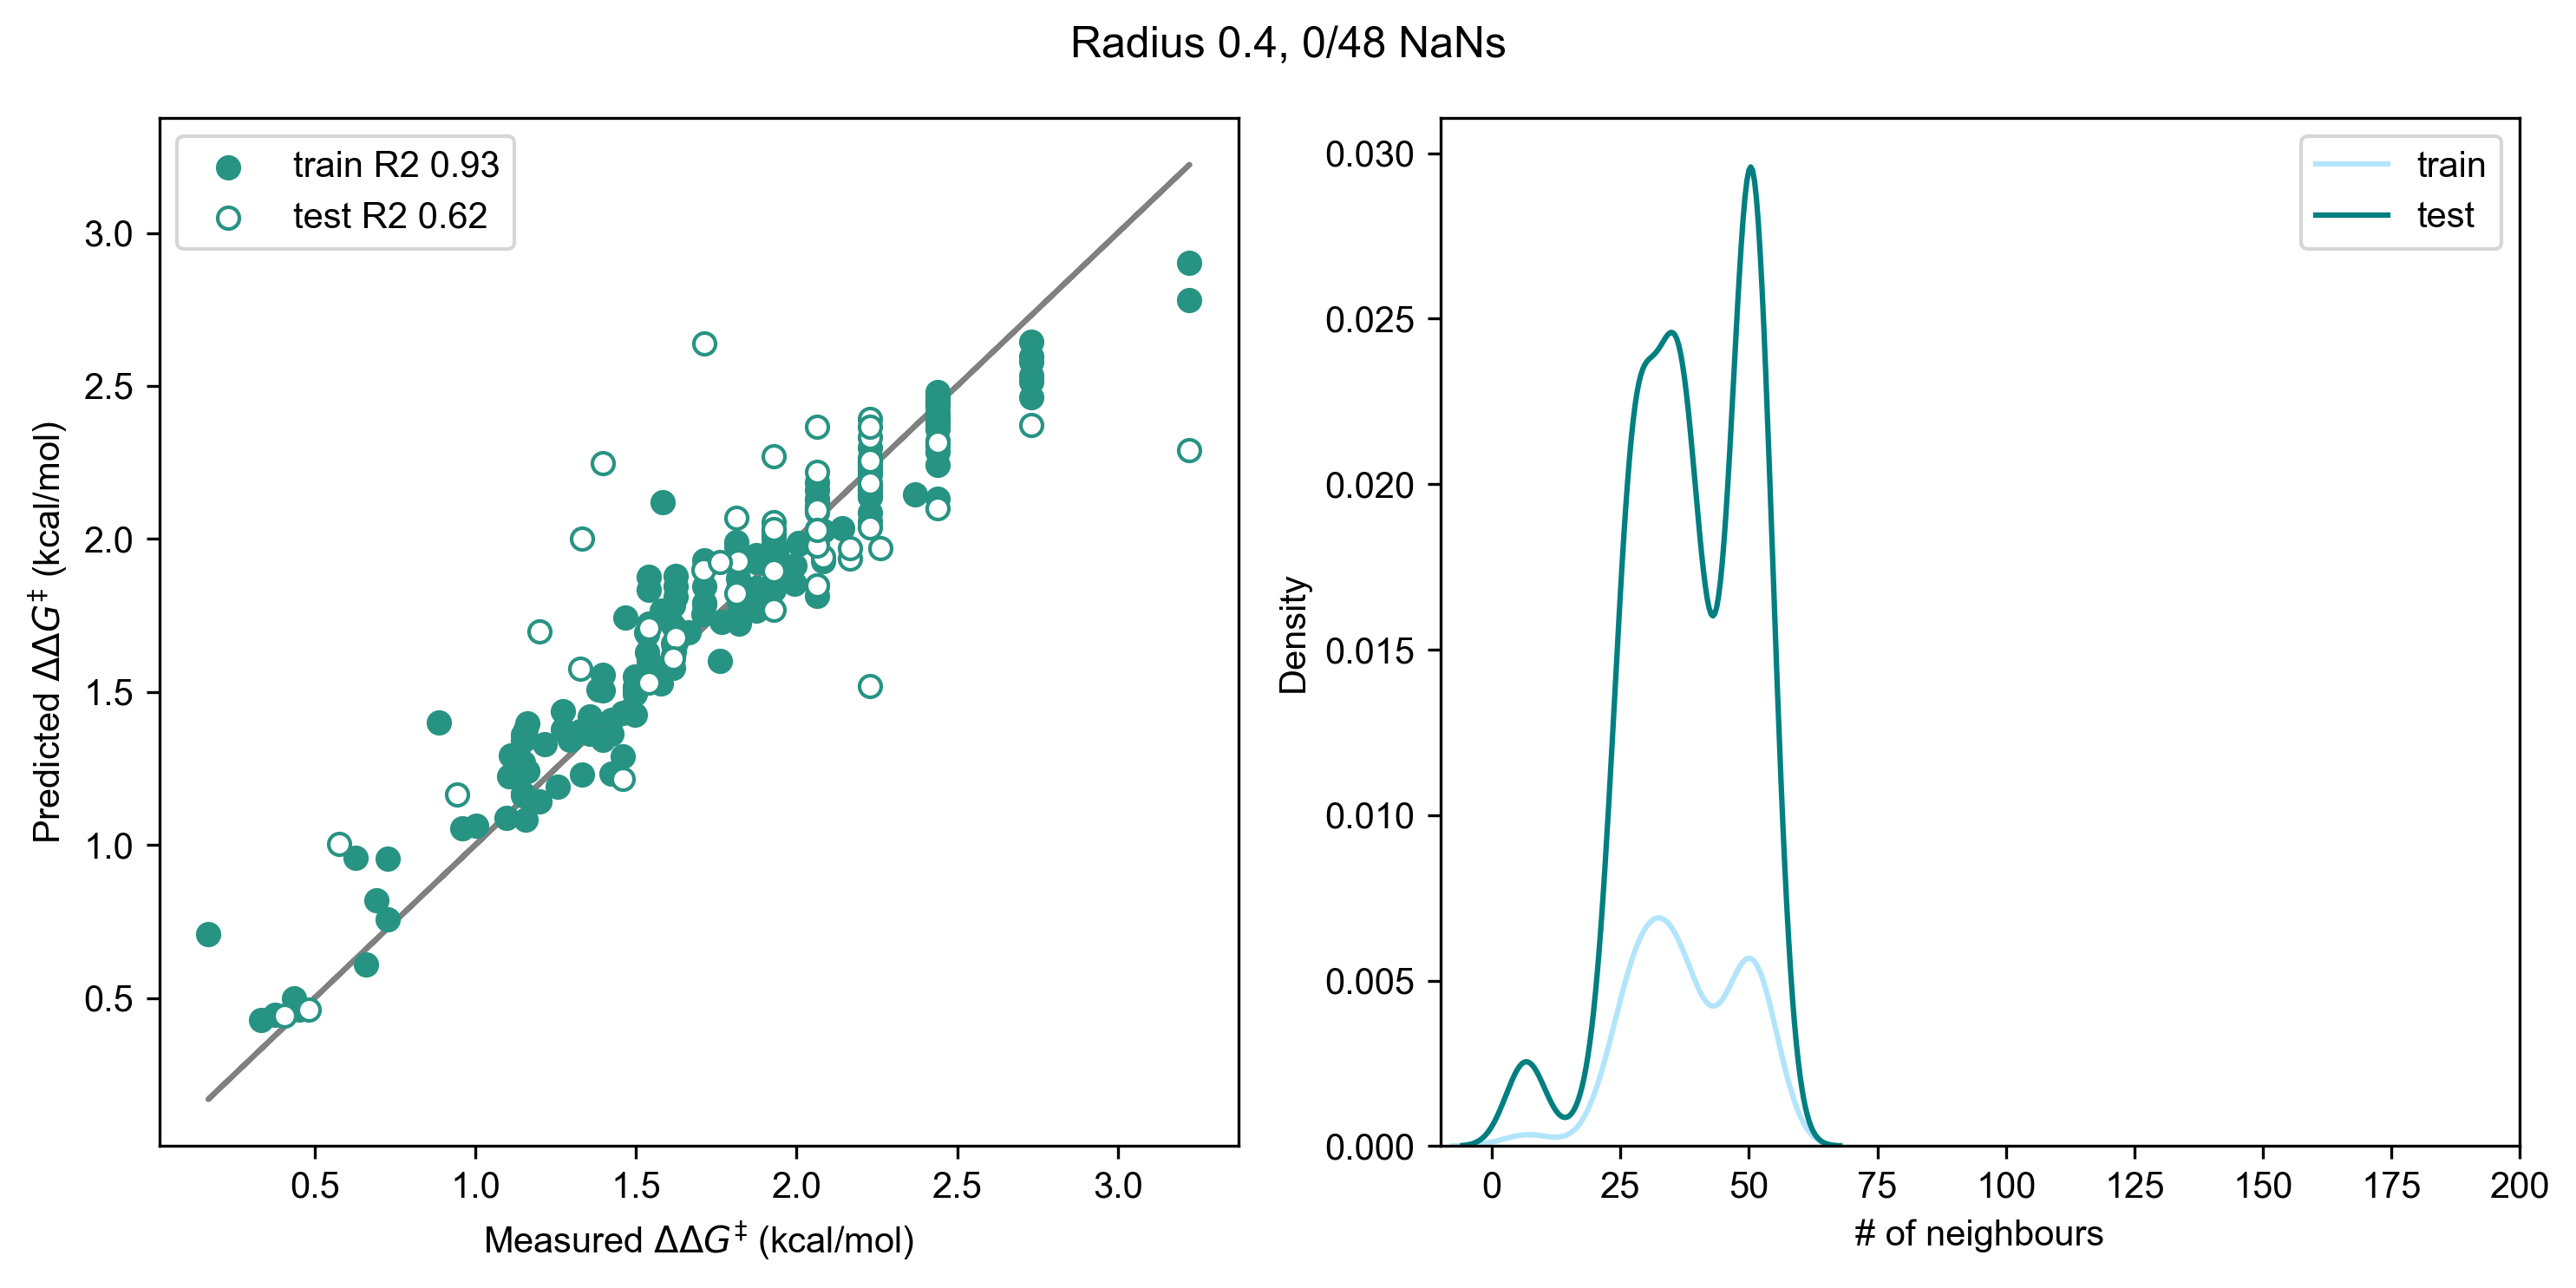

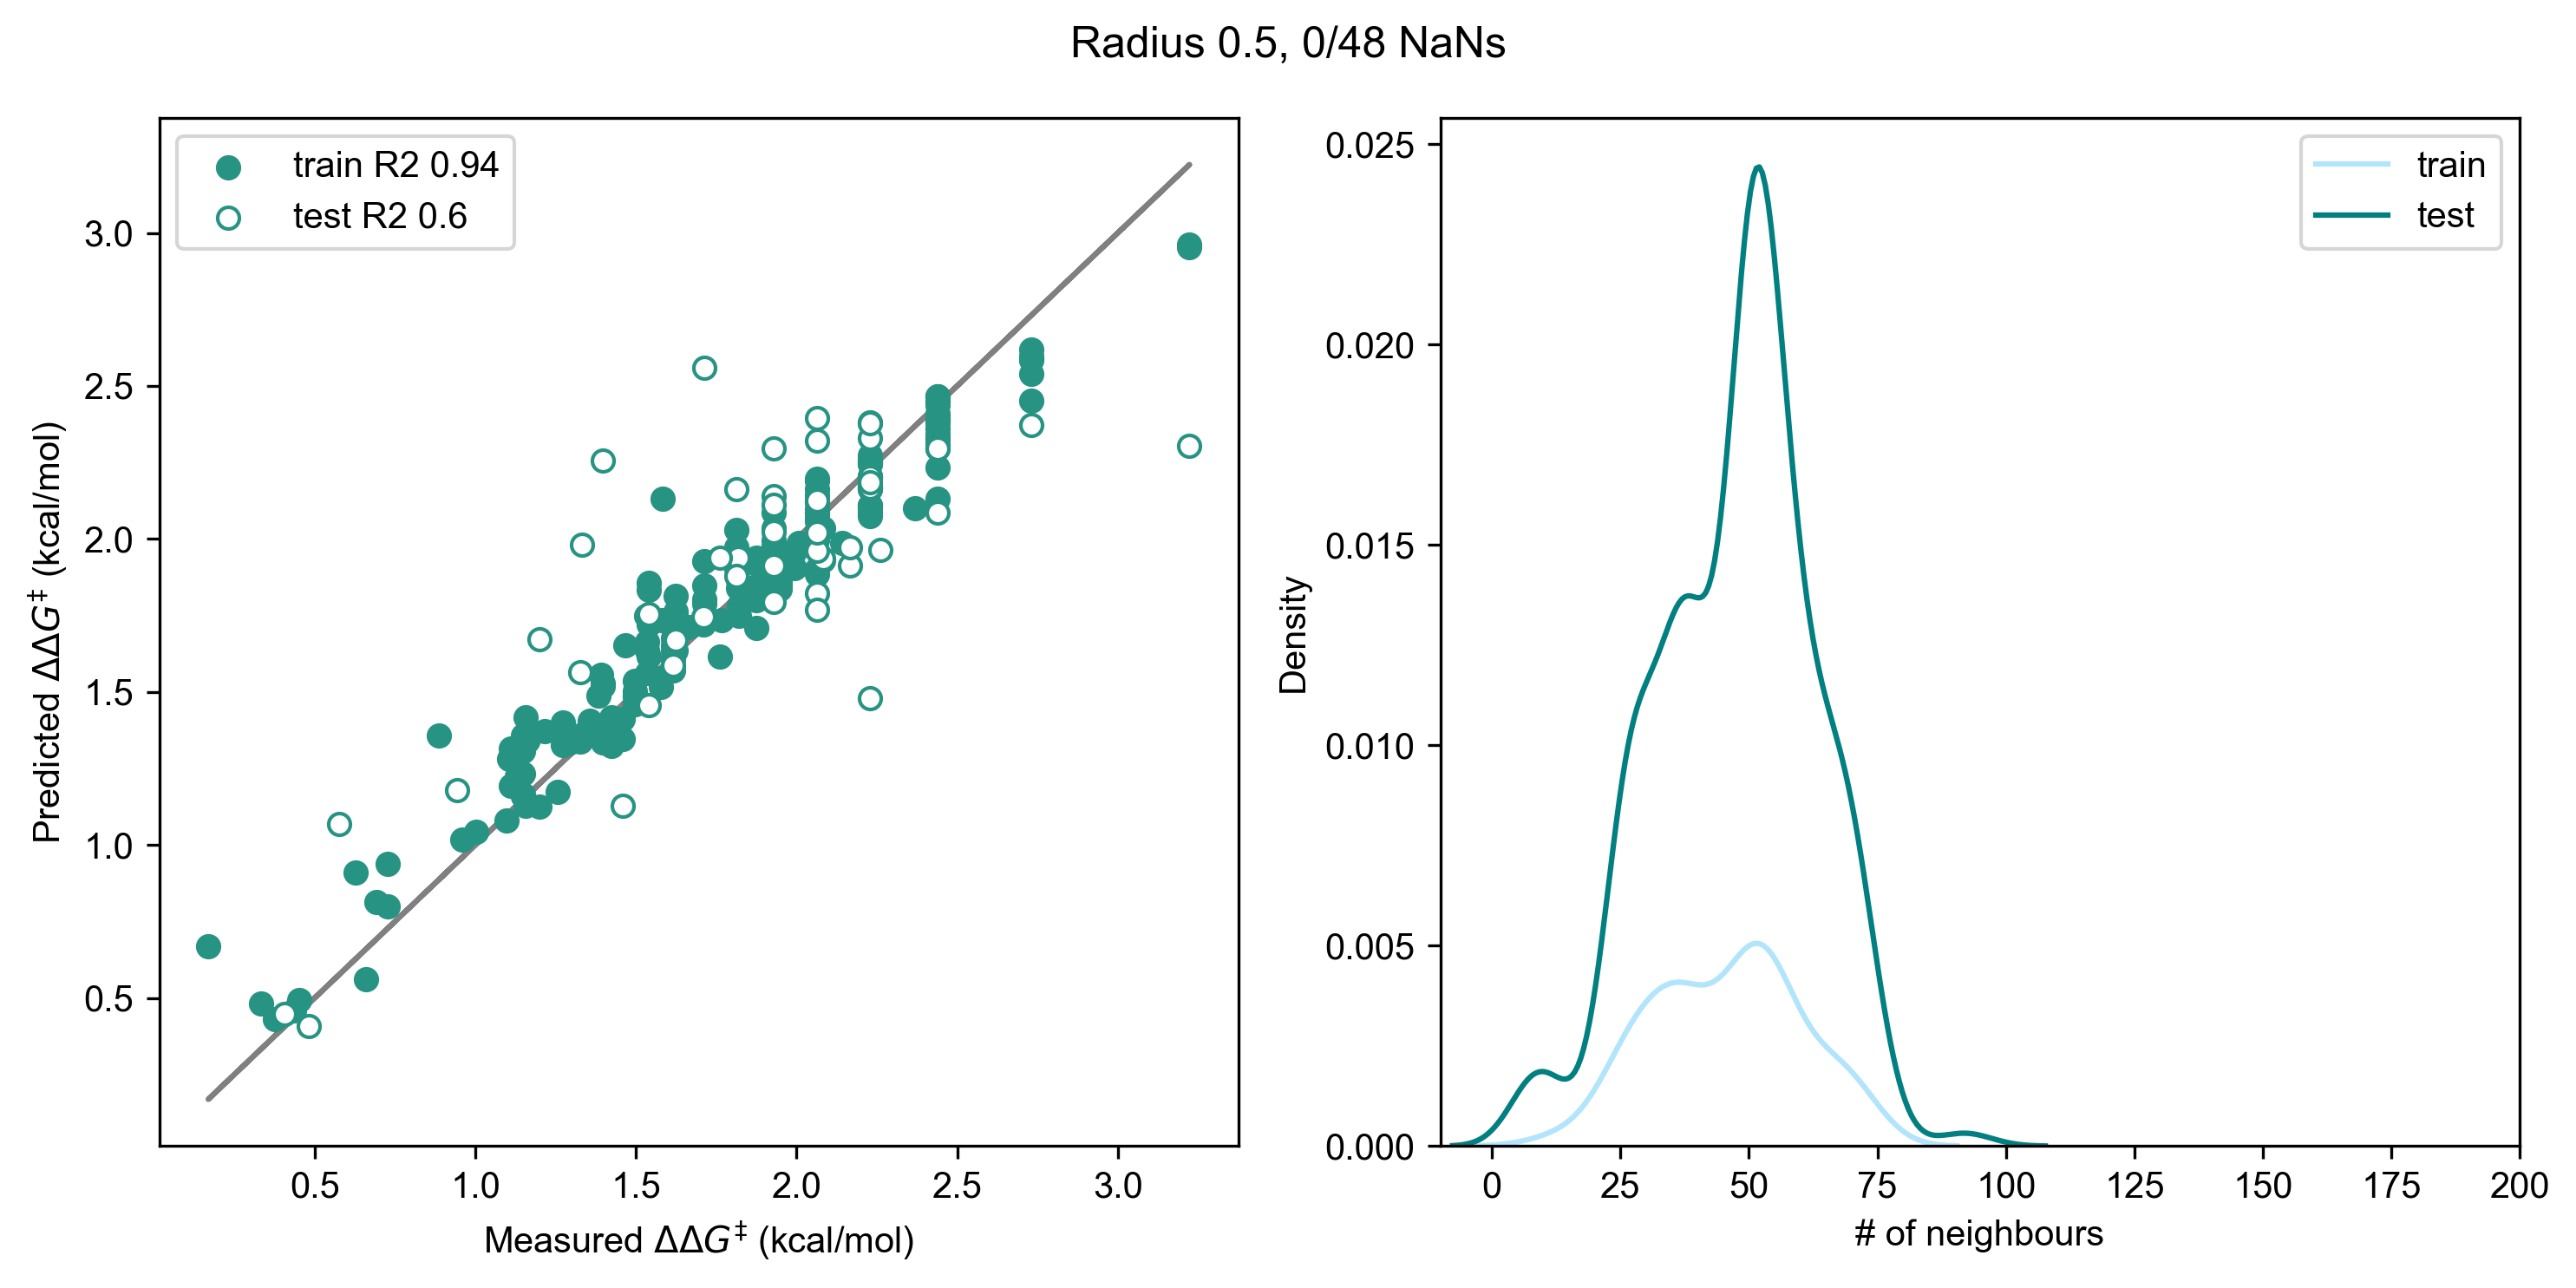

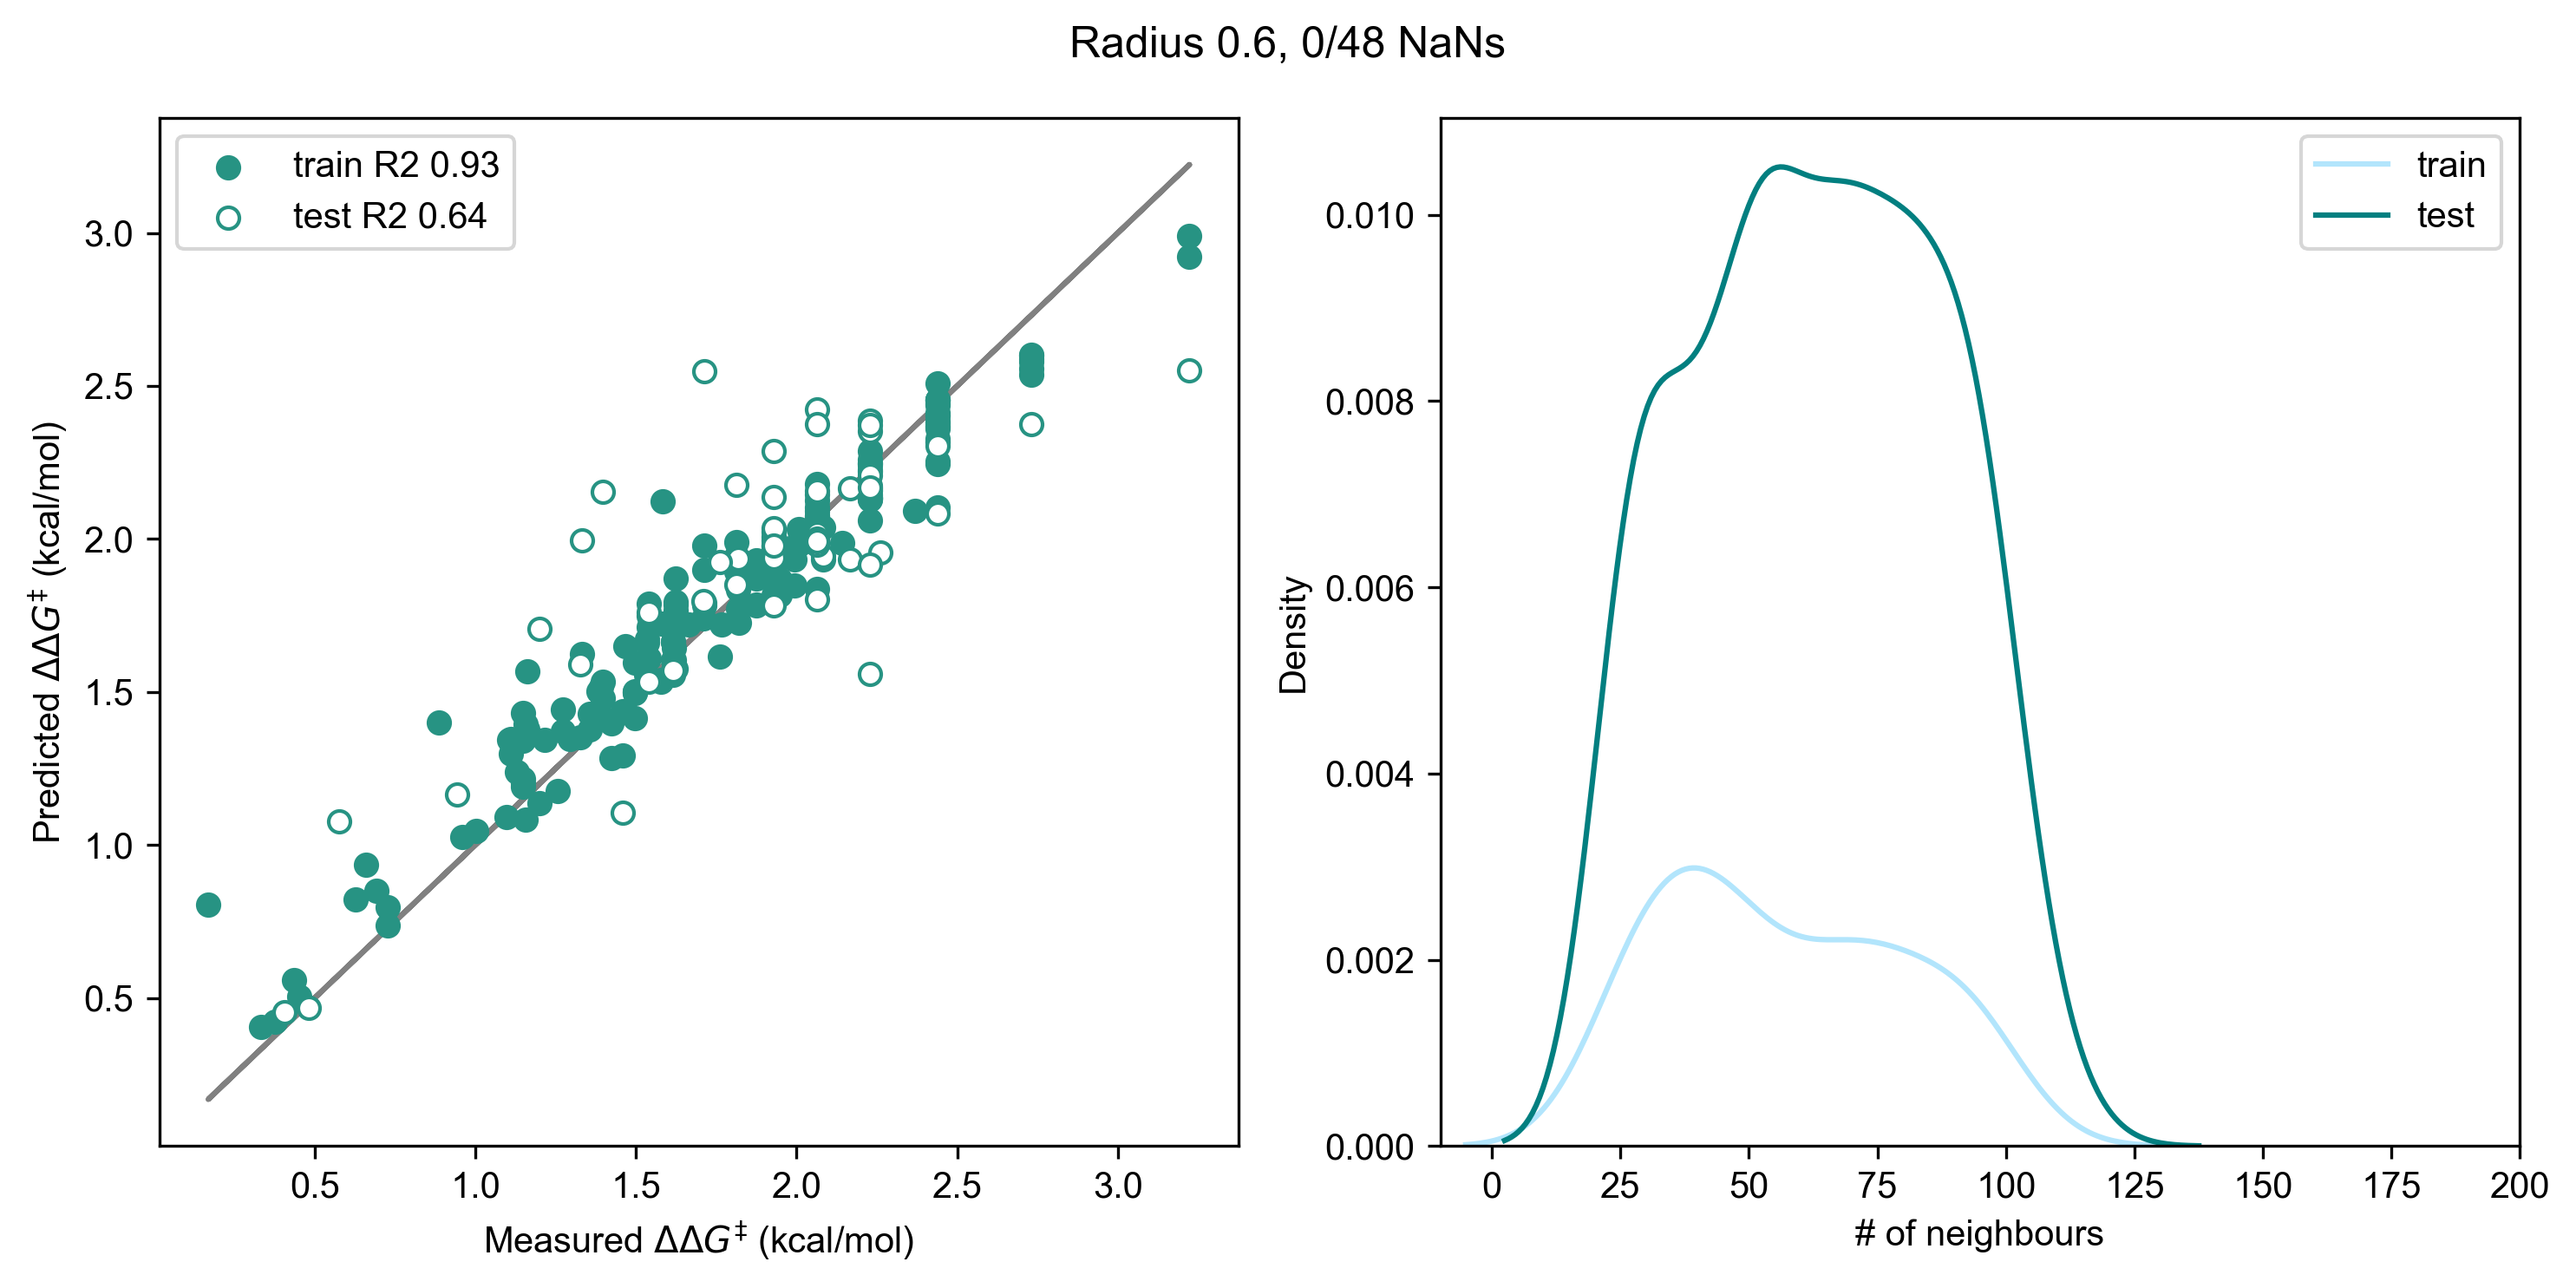

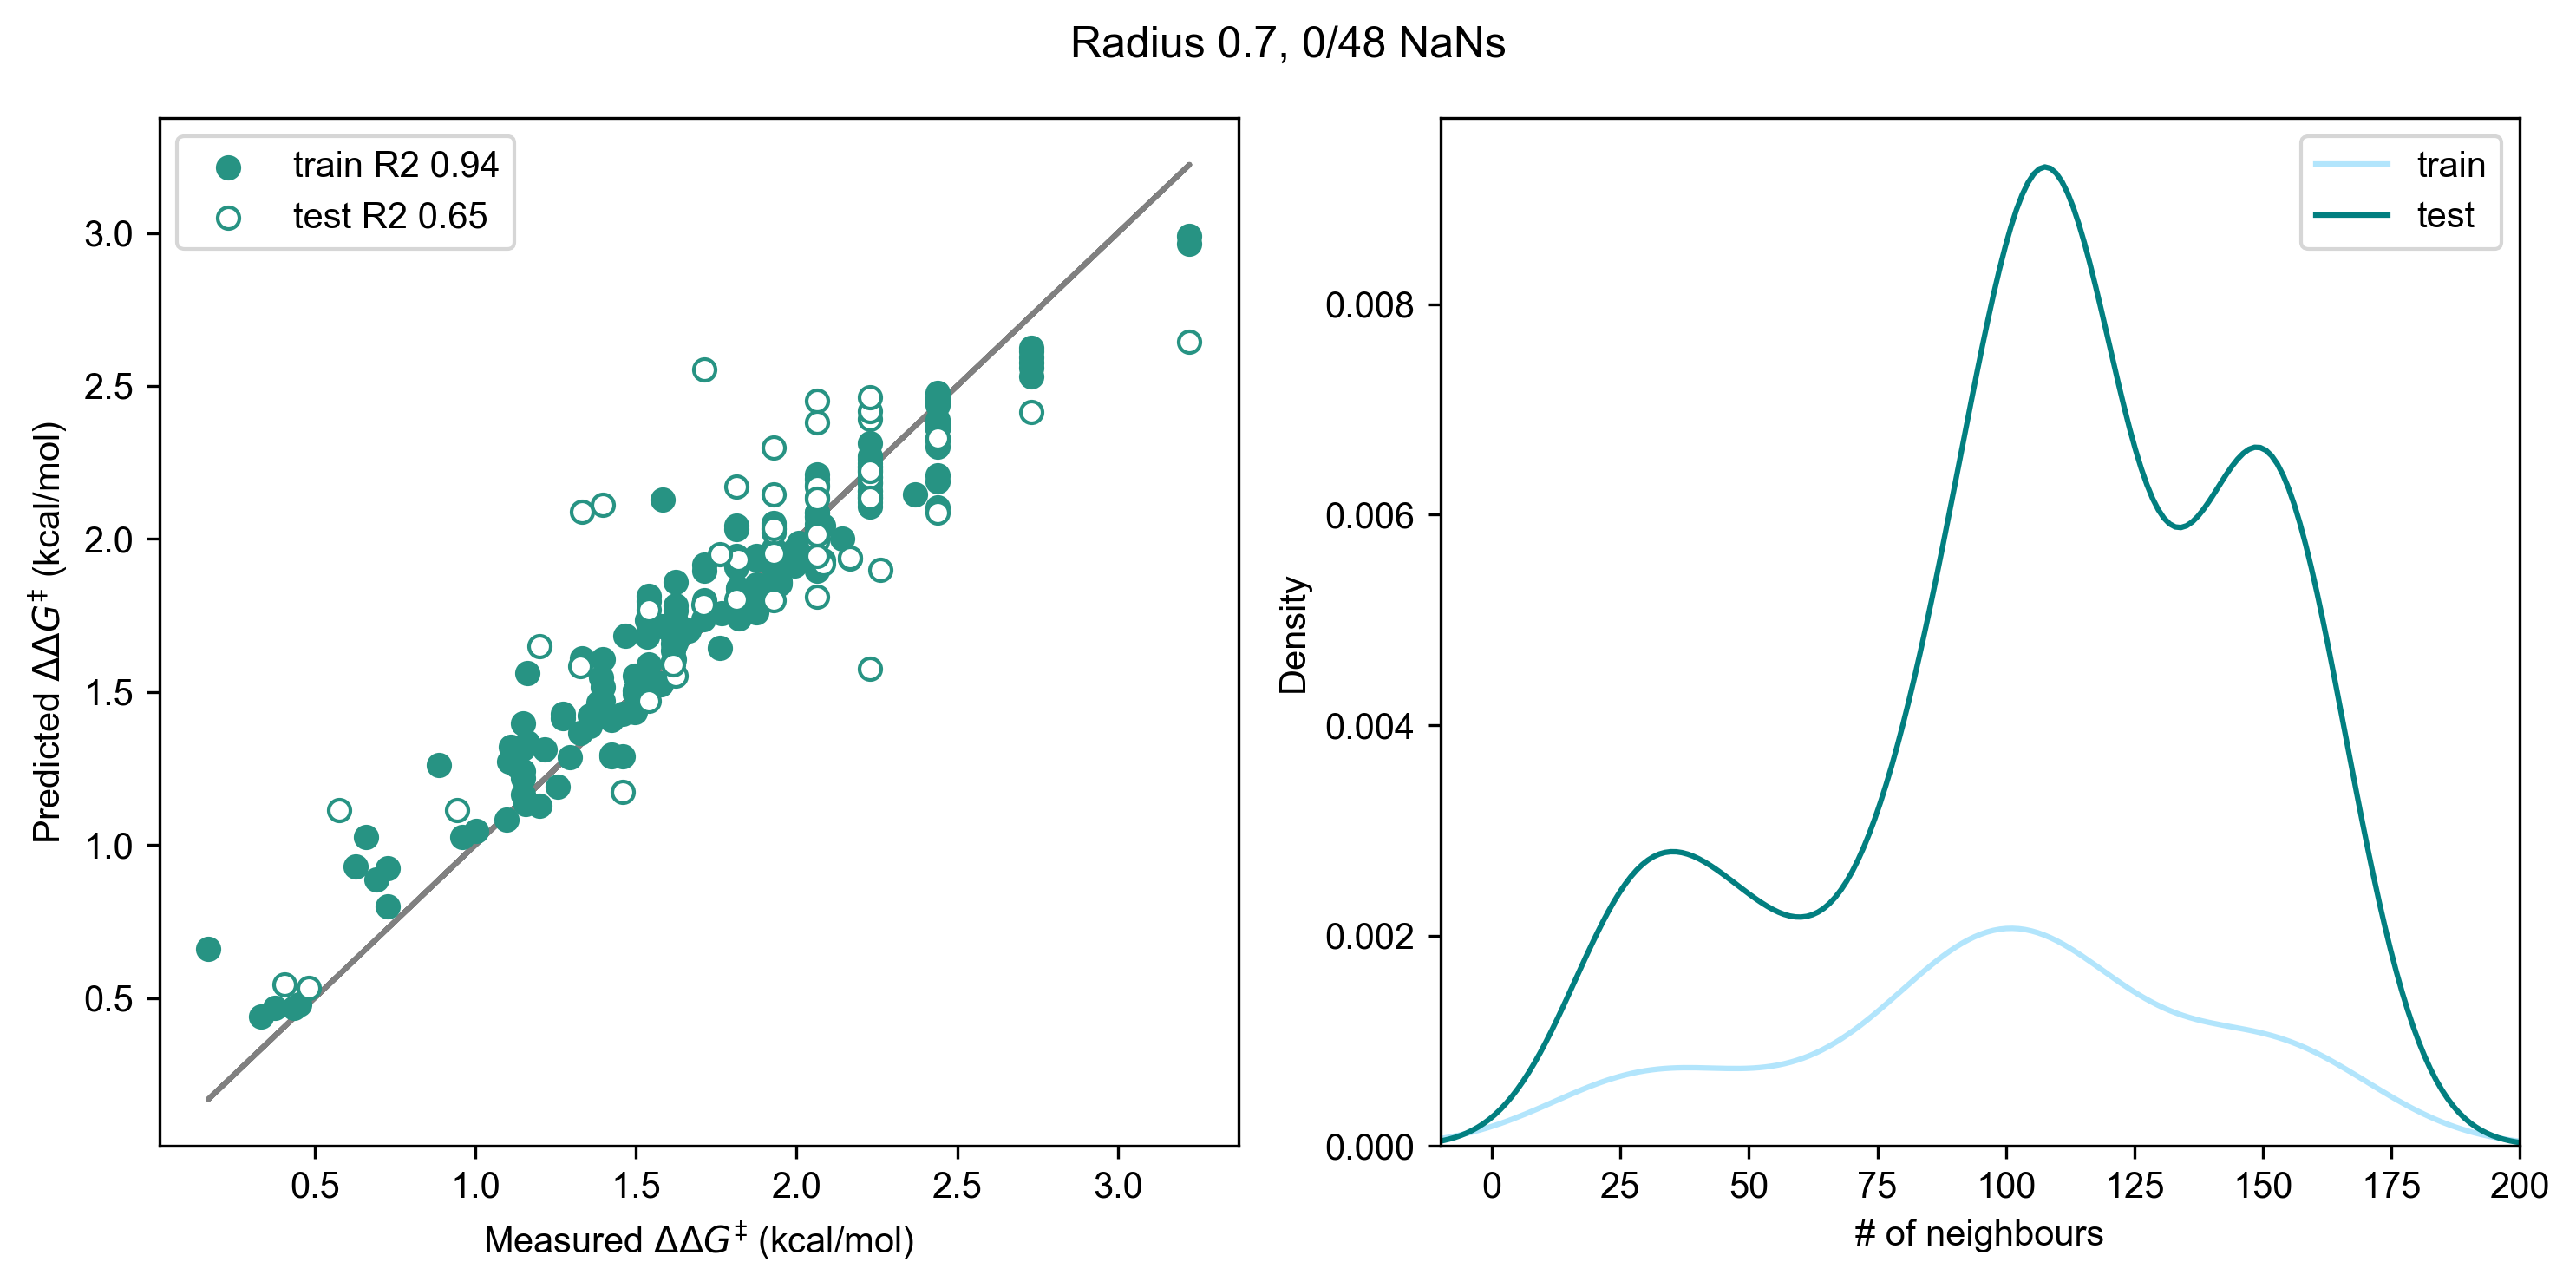

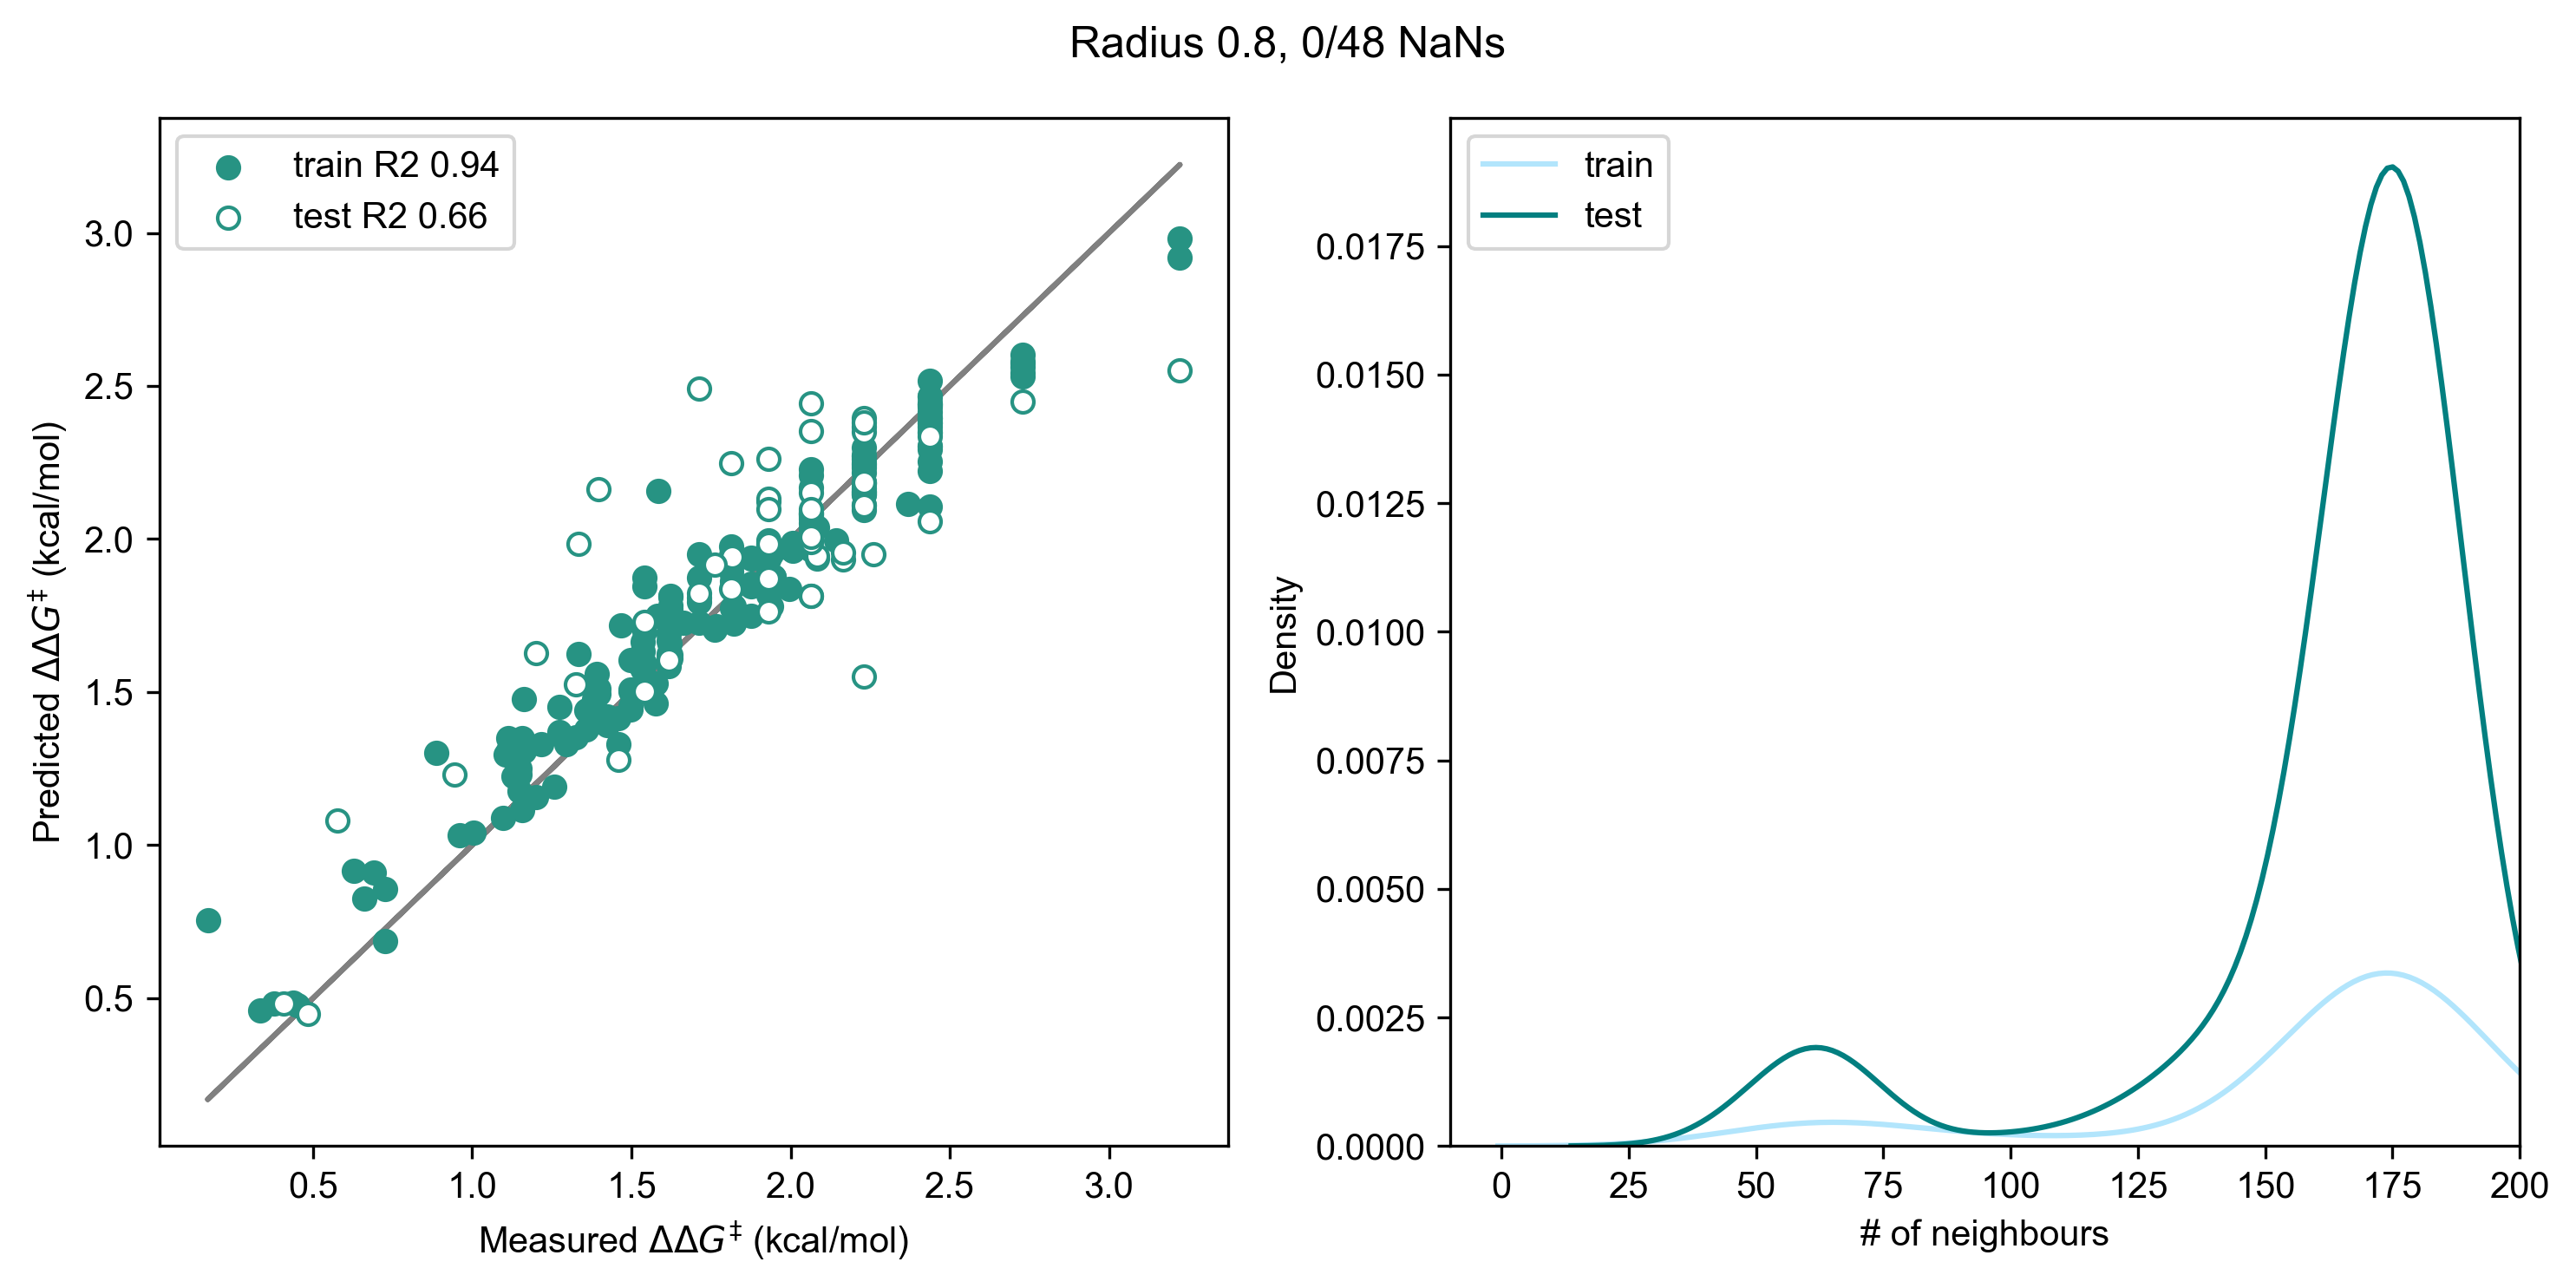

/var/folders/20/gzkvkxzx78g2fg2gh39fz9300000gn/T/ipykernel_73973/3622661288.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


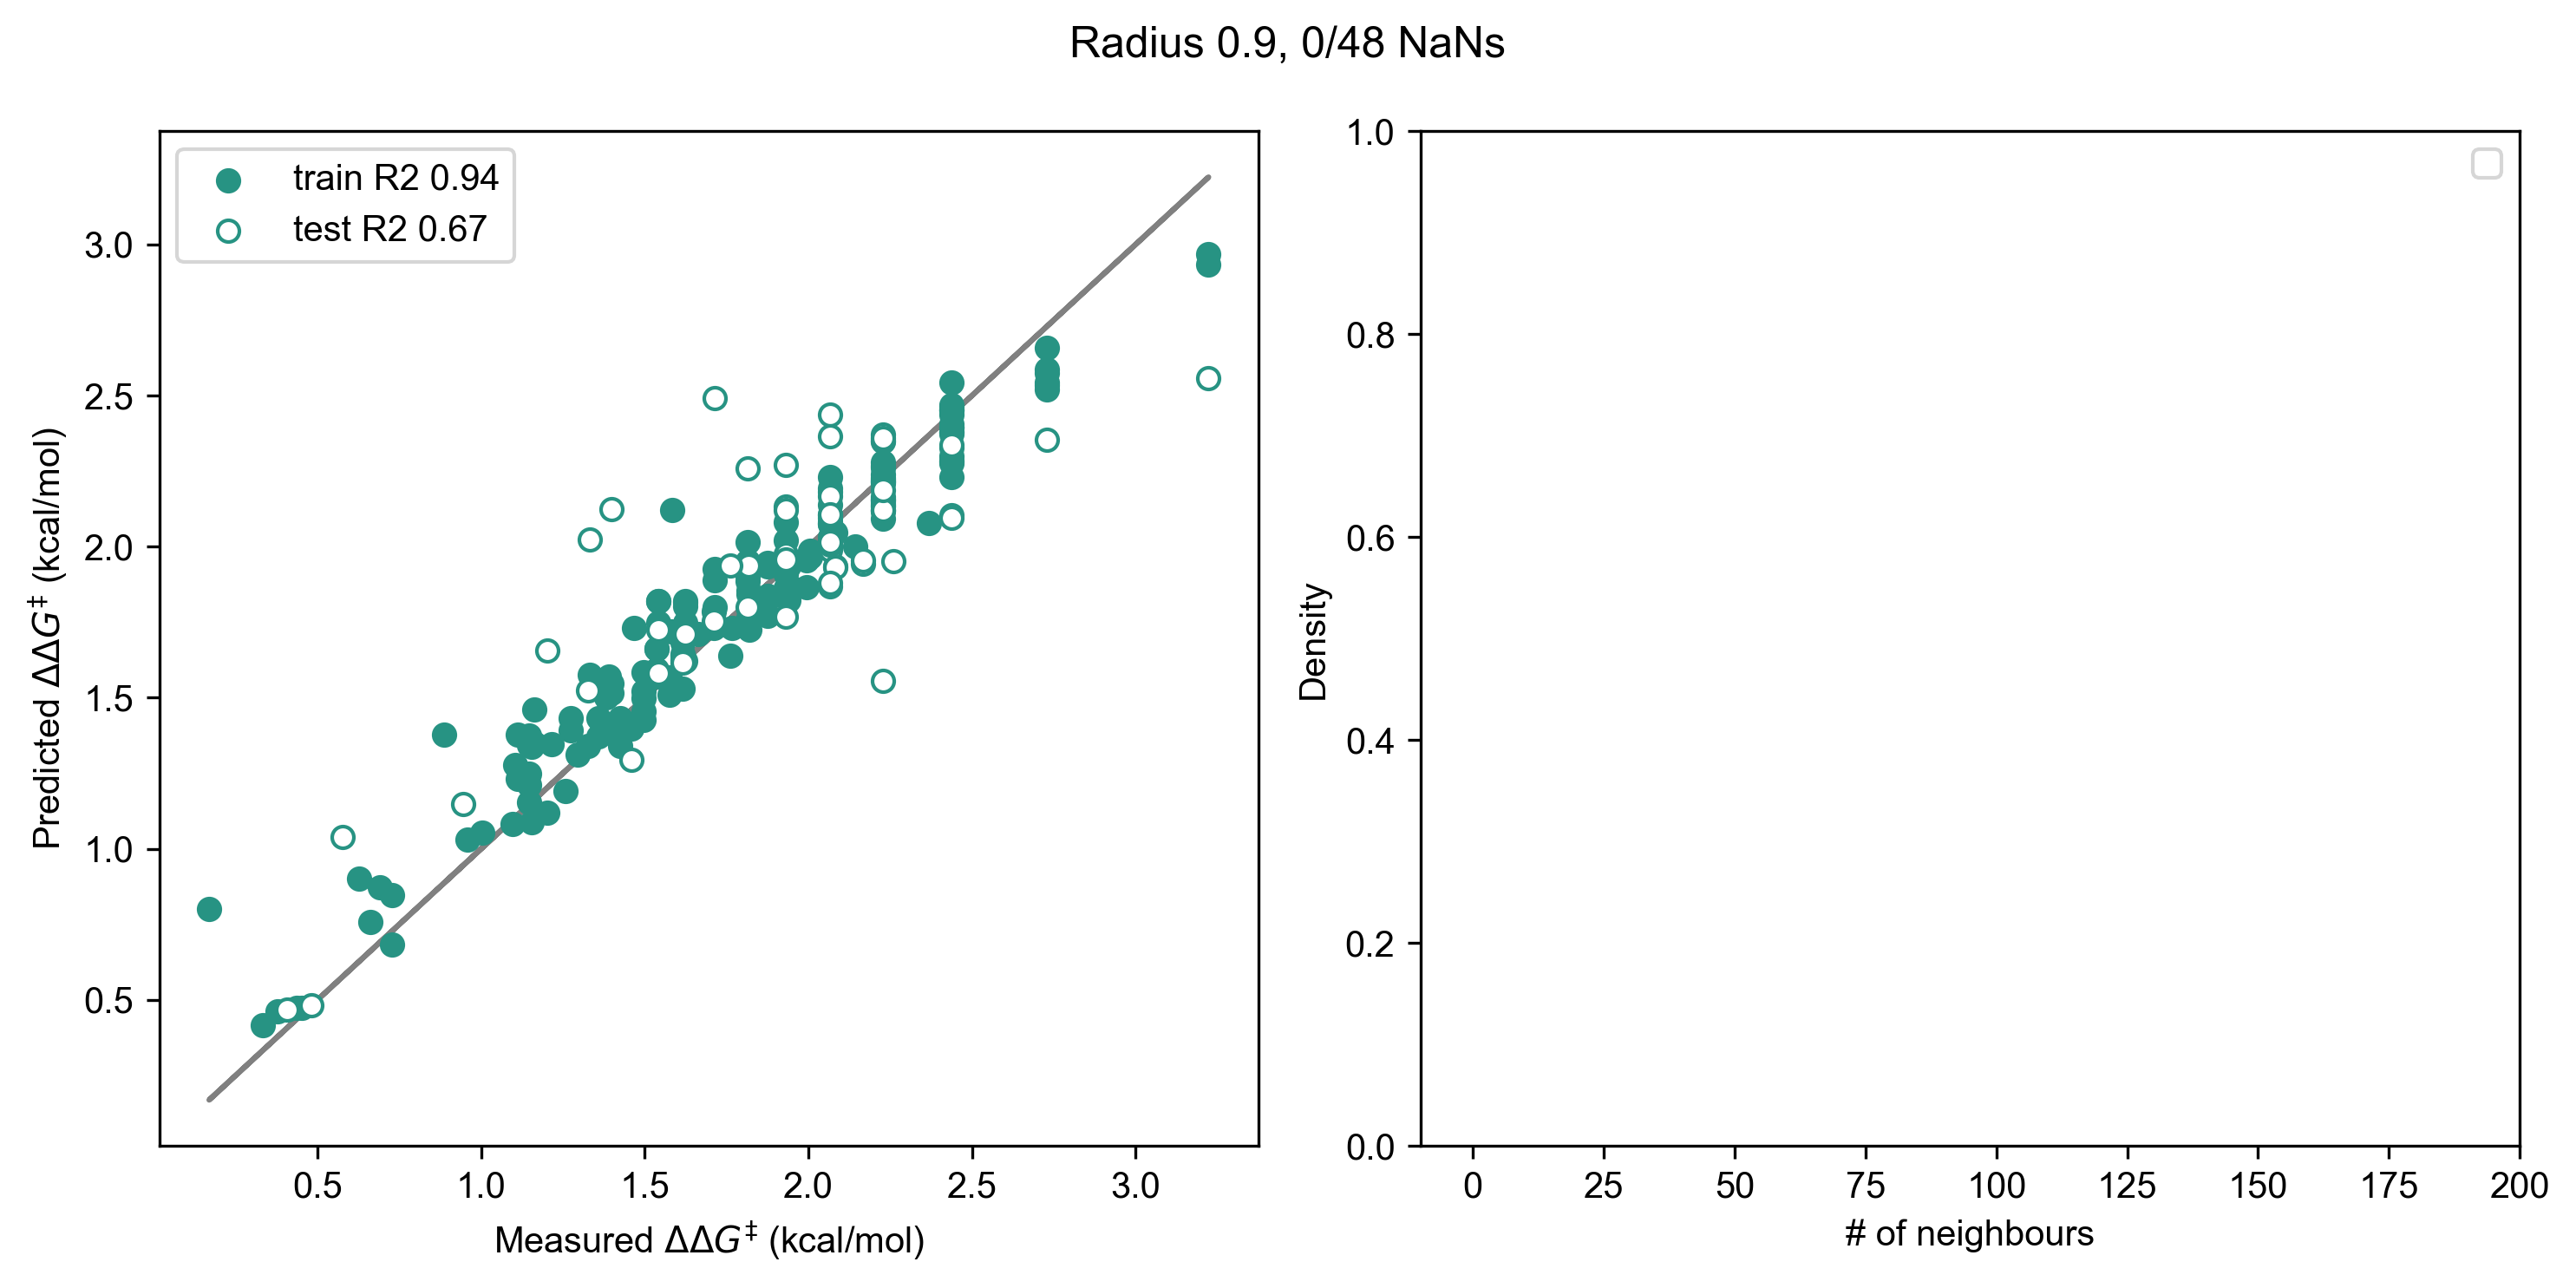

In [7]:
RaRF_mae = []
nans = []
avg_neighbours = []

distances = utils.get_distances(X_train,X_test)

for i in np.divide(range(1,10),10):


    radius_pred, train_neighbours = RaRFRegressor.RaRFRegressor(radius=i, metric='jaccard').train_parallel(X_train,y_train, include_self='True')
    radius_testpred, test_neighbours = RaRFRegressor.RaRFRegressor(radius=i,metric='jaccard').predict_parallel(X_train, y_train, X_test, distances)    
    
    nan_indexes = []
    index = -1
    for prediction in radius_testpred:
        index +=1
        if np.isnan(prediction) == True:
            nan_indexes.append(index)
        
    radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
    y_test_temp = np.delete(y_test,nan_indexes)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)


    ax1.plot(y_train,y_train, color='grey', zorder=0)
    ax1.scatter(y_train,radius_pred, label='train R2 ' + str(round(r2_score(y_train,radius_pred),2)), color='#279383')
    ax1.scatter(y_test_temp,radius_testpred_temp, label='test R2 ' + str(round(r2_score(y_test_temp,radius_testpred_temp,),2)), color='white', edgecolor='#279383')

    ax1.set_xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.set_ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.legend()


    ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])
    ax2.legend(['train', 'test'])
    ax2.set_xlim(-10,200)
    ax2.set_xlabel('# of neighbours')

    fig.suptitle(f'Radius {i}, {len(nan_indexes)}/{len(radius_testpred)} NaNs')
    plt.tight_layout()
    plt.show()

    RaRF_mae.append(mean_absolute_error(y_test_temp,radius_testpred_temp))
    
    nans.append(len(nan_indexes))

    avg_neighbours.append(np.average([test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]))

